# Histogram plotting

In [1]:
import numpy as np
import ultraplot as plt
from ipywidgets import interact
from ipywidgets import widgets

import psdist as ps
import psdist.plot as psv

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["colorbar.width"] = "1.2em"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## 2D histograms

In [3]:
seed = 1951
resolution = 50

rng = np.random.default_rng(seed)
coords = 2 * [np.linspace(-5.0, 5.0, resolution)]

hist = ps.Histogram(coords=coords)
X, Y = hist.meshgrid()

values = np.zeros((resolution, resolution))
for _ in range(4):
    loc = rng.uniform(-2.0, +2.0, size=2)
    scale = rng.uniform(+0.5, +1.5, size=2)
    values += np.exp(
        -0.5 * (((X - loc[0]) / scale[0]) ** 2 + ((Y - loc[1]) / scale[1]) ** 2)
    )
values = values**2
hist.values = values

hist.values /= hist.values.max()
hist.values[hist.values < 0.001] = 0.0

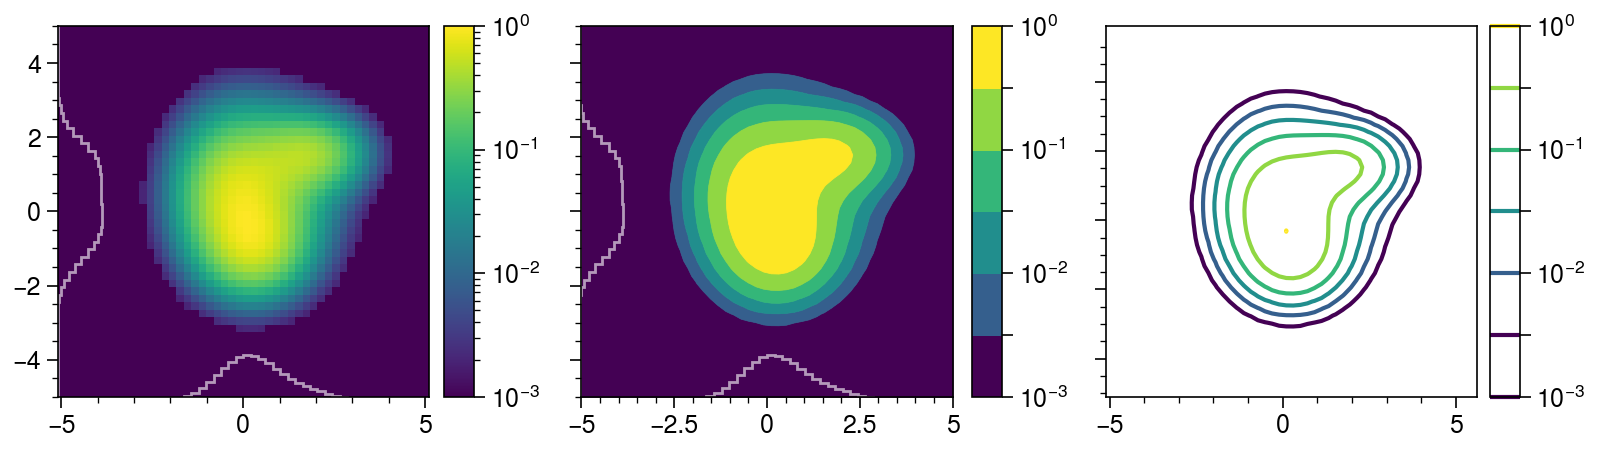

In [4]:
fig, axs = plt.subplots(ncols=3, figwidth=8.0)
for ax, kind in zip(axs, ["pcolor", "contourf", "contour"]):
    psv.plot_hist(
        hist,
        kind=kind,
        process_kws=dict(),
        offset=1.0,
        offset_type="relative",
        mask=False,
        profx=True,
        profy=True,
        prof_kws=dict(kind="step"),
        rms_ellipse=False,
        rms_ellipse_kws=dict(),
        colorbar=True,
        colorbar_kw=dict(),
        norm="log",
        vmax=1.0,
        vmin=1.00e-03,
        ax=ax,
    )

### Joint plot 

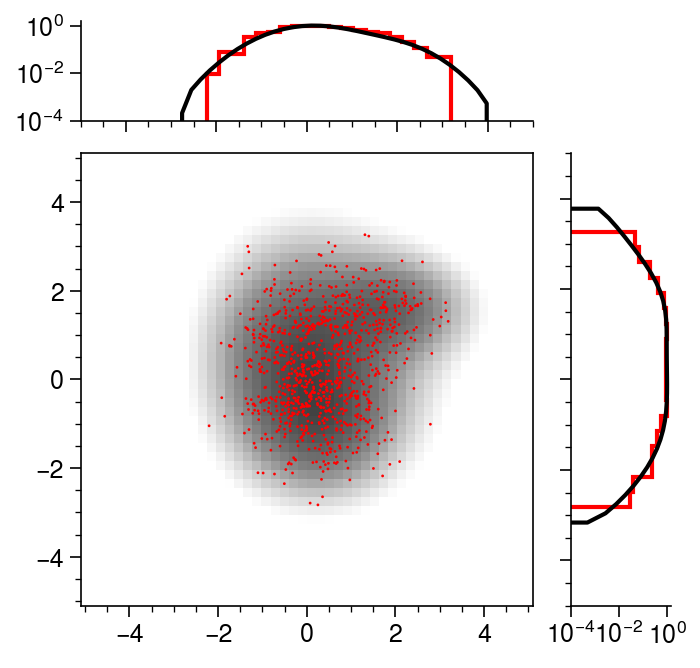

In [5]:
grid = psv.JointGrid(
    panel_kws=dict(width=0.5),
    panel_fmt_kws=None,
    panel_fmt_kws_x=None,
    panel_fmt_kws_y=None,
    figwidth=3.5,
)
grid.plot_hist(
    hist,
    panel_plot_kws=dict(scale="max", kind="line"),
    norm="log",
    vmax=1.0,
    cmap=plt.Colormap("greys", left=0.0, right=0.8),
)

grid.plot_points(
    hist.sample(1_000),
    panel_hist_kws=dict(bins="auto"),
    panel_plot_kws=dict(scale="max", kind="step", color="red"),
    kind="scatter",
    s=1.0,
    color="red",
    label="samples",
)
grid.ax_panel_x.format(yscale="log", yformatter="log", ymin=0.0001)
grid.ax_panel_y.format(xscale="log", xformatter="log", xmin=0.0001)
plt.show()

## ND histograms 

In [6]:
resolution = 50
ndim = 4
xmax = 5.0

rng = np.random.default_rng(123)

dims = ["x", "px", "y", "py", "z"][:ndim]
pairs = [(i, j) for i in range(ndim) for j in range(i)]

shape = tuple(ndim * [resolution])
coords = ndim * [np.linspace(-xmax, xmax, resolution)]
COORDS = np.meshgrid(*coords, indexing="ij")
R = np.sqrt(np.sum([C**2 for C in COORDS], axis=0))

# Start with gaussian * cosine
values = 0.25 * np.exp(-0.5 * (R / 2.0)) * np.cos(3.0 * R) ** 2
values[R > 4.0] = 0.0
for _ in range(8):
    # Generate a Gaussian distribution with random mean and std.
    loc = rng.uniform(-3.0, +3.0, size=ndim)
    scale = rng.uniform(+0.5, +1.0, size=ndim)
    argument = np.zeros(shape)
    for i in range(ndim):
        argument += ((COORDS[i] - loc[i]) / scale[i]) ** 2

    # Add random linear correlations.
    for i, j in pairs:
        r = rng.uniform(-0.5, 0.5)
        U = (COORDS[i] - loc[i]) / scale[i]
        V = (COORDS[j] - loc[j]) / scale[j]
        argument += r * U * V
    values += np.exp(-0.5 * argument)

hist = ps.Histogram(values=values, coords=coords)
hist.values = hist.values / hist.values.max()
hist.values[hist.values < 0.0001] = 0.0

### Corner plot 

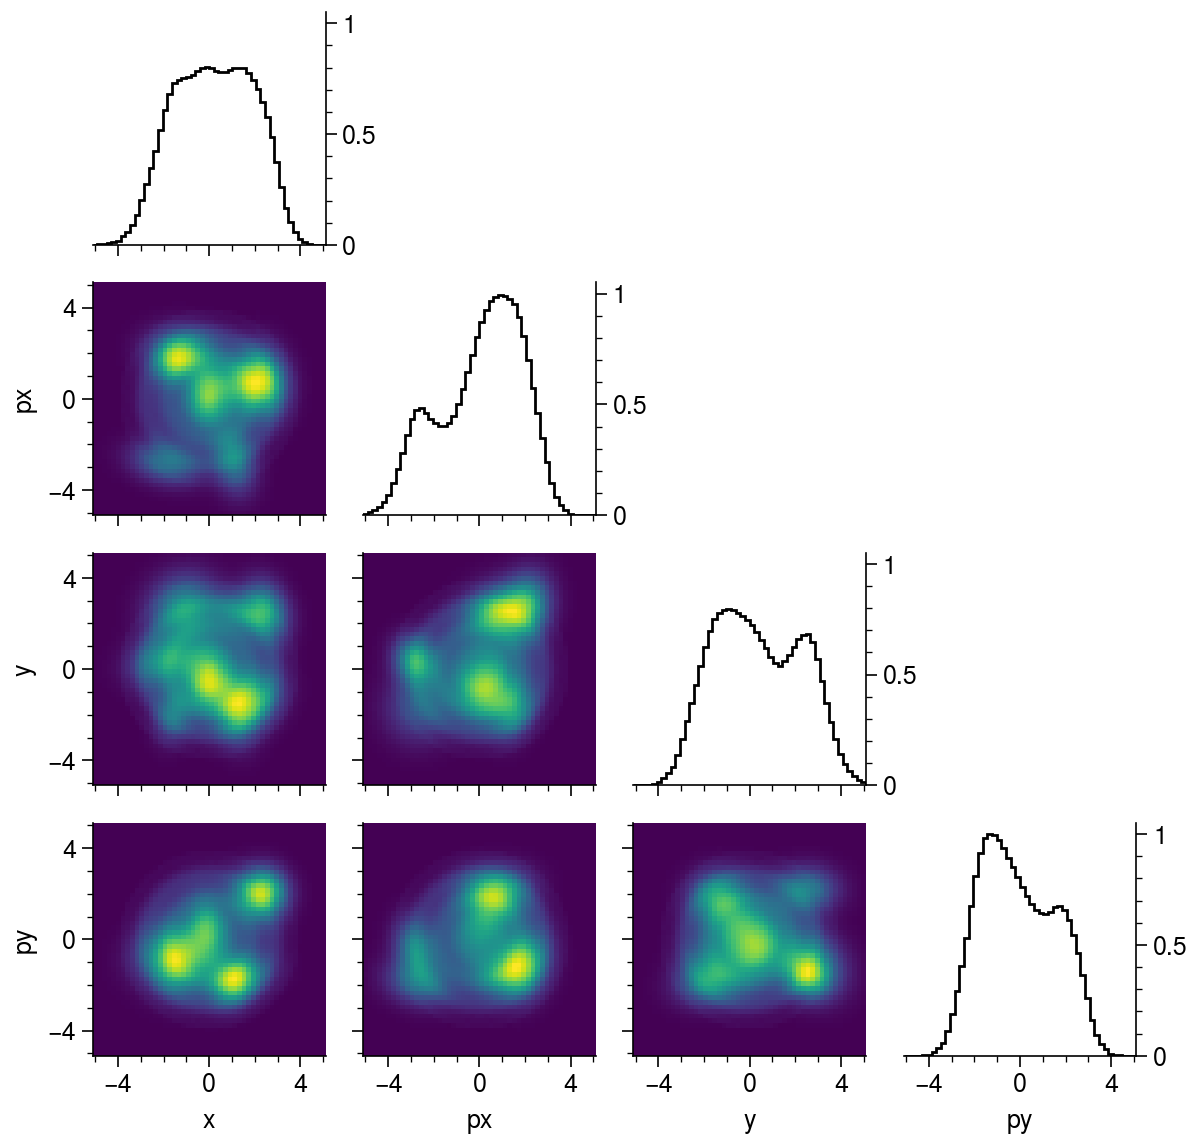

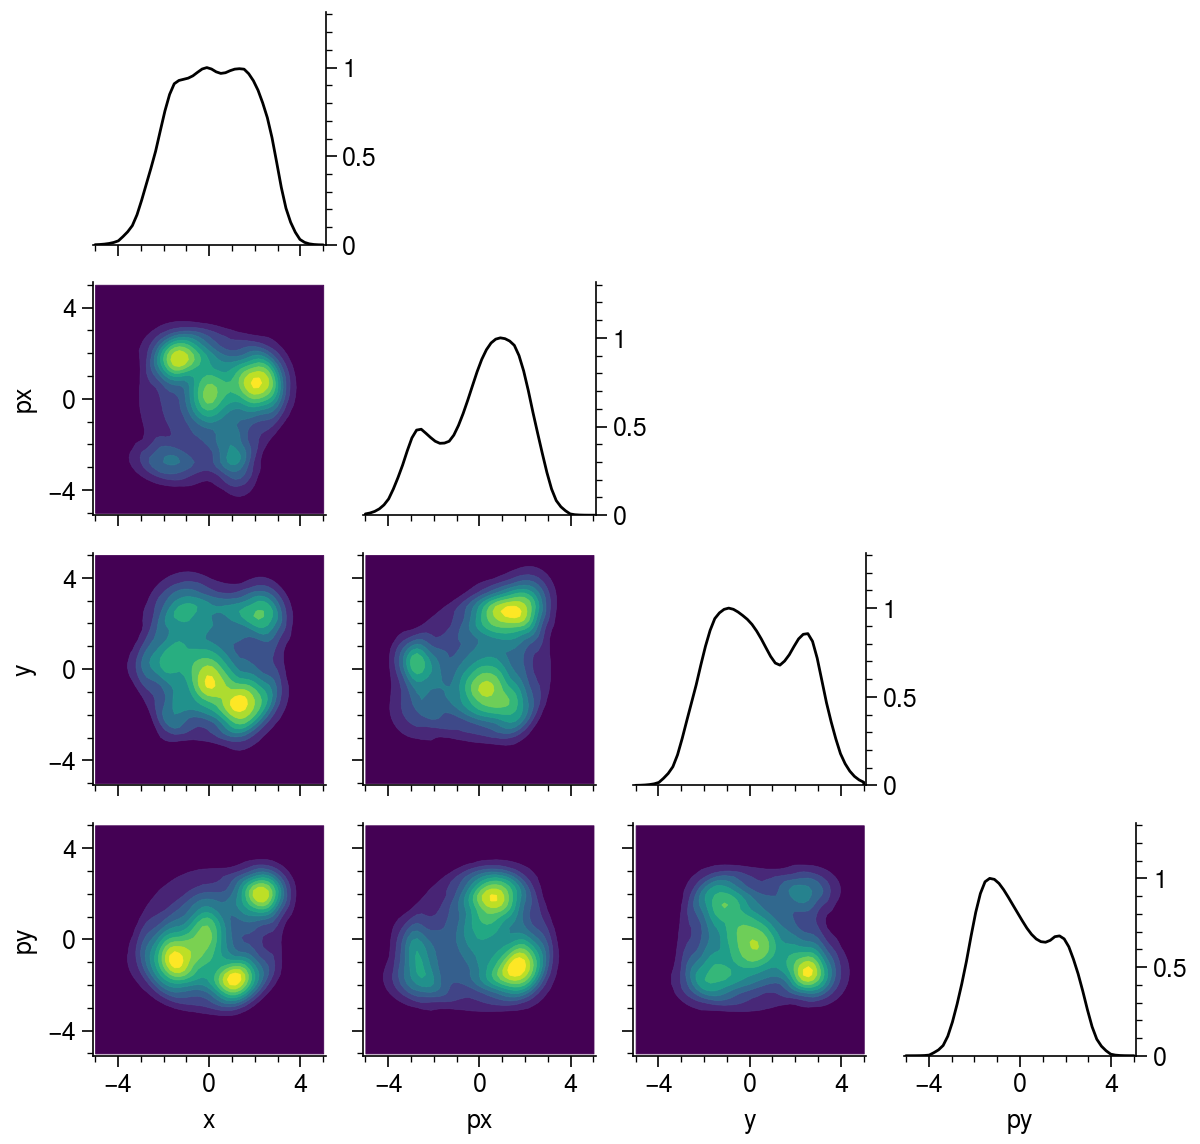

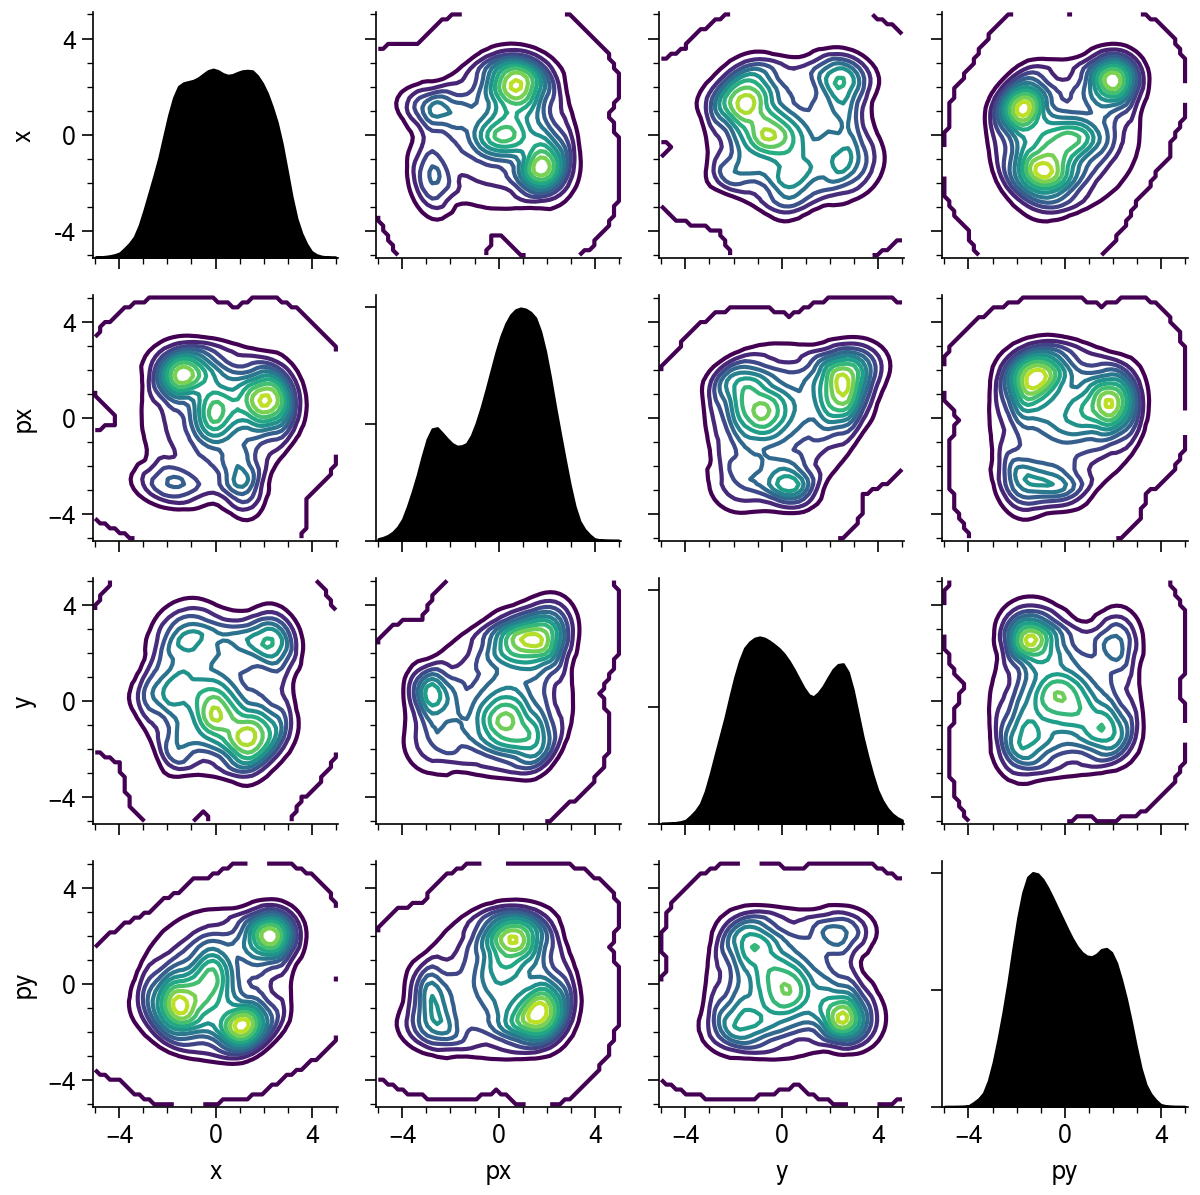

In [7]:
kinds = ["pcolor", "contourf", "contour"]
diag_kws = [
    dict(kind="step", fill=False),
    dict(kind="line", fill=False),
    dict(kind="line", fill=True),
]
diag_shrink = [1.0, 0.8, 1.0]
for i, kind in enumerate(kinds):
    grid = psv.hist.plot_corner(
        hist,
        grid_kws=dict(
            corner=(i < 2),
            diag_shrink=diag_shrink[i],
            diag_share=(i != 1),
            diag_rspine=(i < 2),
            space=1.5,
            labels=dims,
        ),
        diag_kws=diag_kws[i],
        kind=kind,
    )
    plt.show()

Don't plot diagonals; plot 1D projections on top of 2D projections.

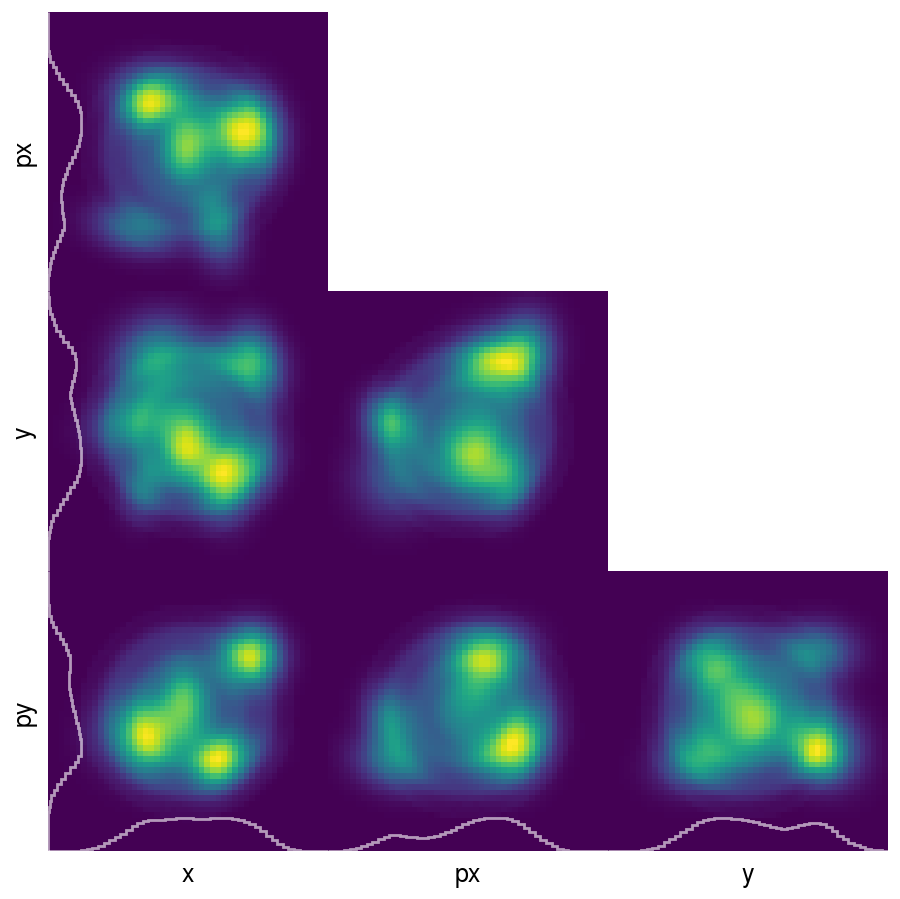

In [8]:
grid = psv.hist.plot_corner(
    hist,
    grid_kws=dict(diag=False, space=0.0, labels=dims),
    prof_edge_only=True,
    profx=True,
    profy=True,
    prof_kws=dict(color="white"),
)

# grid.set_labels(dims)
grid.axs.format(xspineloc="neither", yspineloc="neither")
plt.show()

Use `CornerGrid`; add 1D spines, logarithmic colormap and scaling.

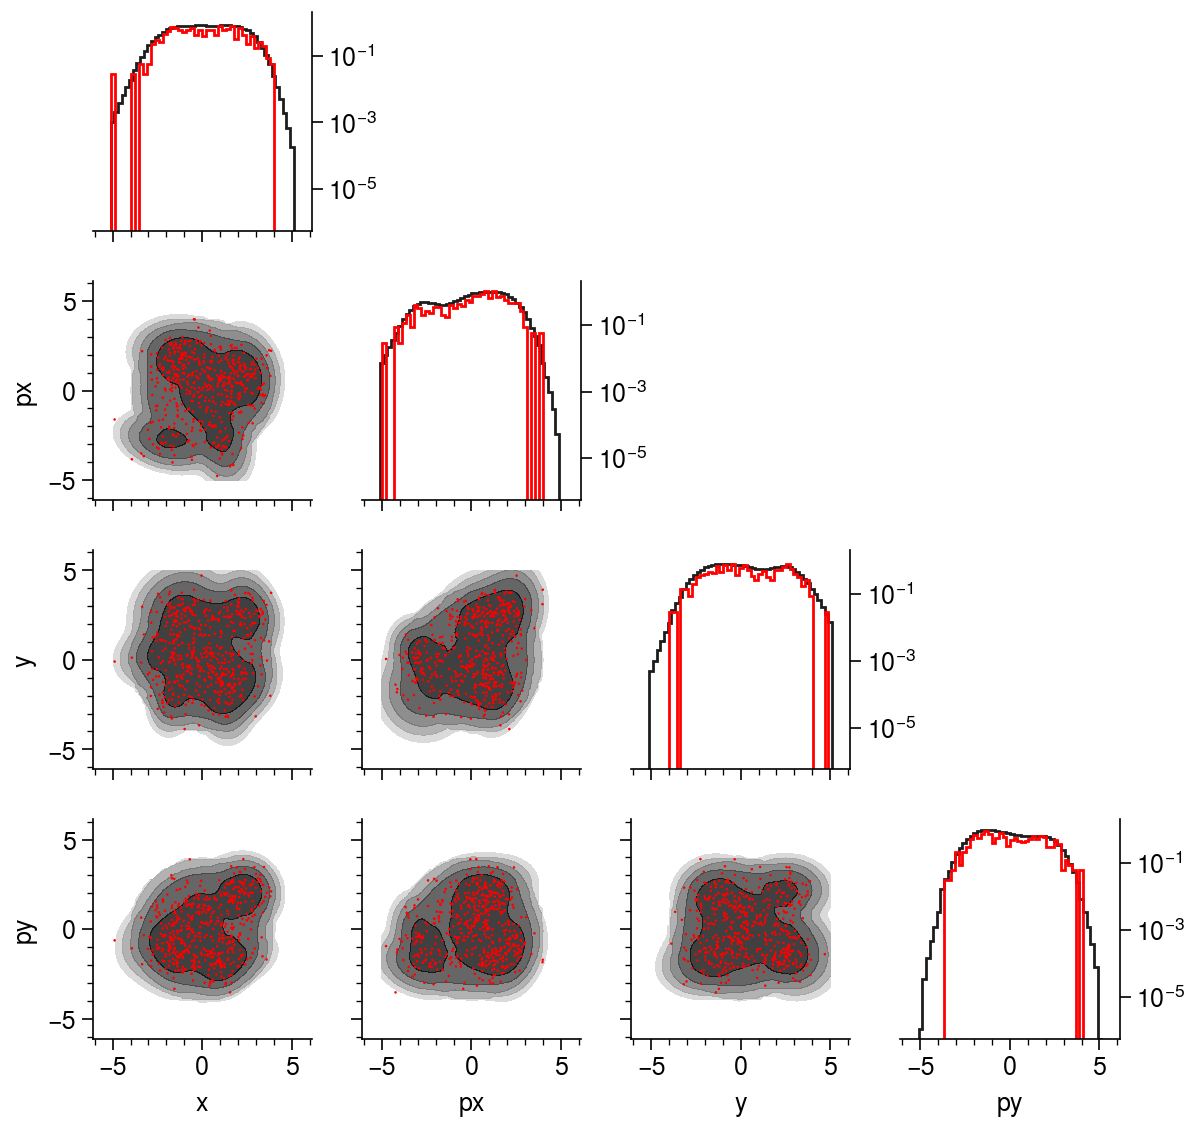

In [9]:
cmap = plt.Colormap("grays")

grid = psv.CornerGrid(
    values.ndim,
    corner=True,
    diag=True,
    diag_share=True,
    space=2.0,
    diag_rspine=True,
    labels=dims,
)
grid.plot_hist(
    hist,
    cmap=cmap,
    diag_kws=dict(color=cmap(0.9)),
    process_kws=dict(scale="max"),
    kind="contourf",
    norm="log",
    vmax=1.0,
    vmin=0.001,
    alpha=0.75,
)
grid.plot_points(
    ps.sample_hist(hist, size=500),
    update_limits=True,
    diag_kws=dict(color="red"),
    kind="scatter",
    c="red",
    s=0.85,
)
grid.set_limits(hist.limits * 1.2)
grid.set_diag_scale("log")
plt.show()

### Slice matrix

This plot shows the dependence of the $x$-$p_x$ distribution on $y$ and $y'$: $f(x, p_x | y, p_y)$. The 3D marginal distributions $f(x, p_x, y | p_y)$ and $f(x, p_x, p_y | y)$ are shown on the right and bottom panels. The full projection $f(x, p_x)$ is shown on the bottom right.

norm = None


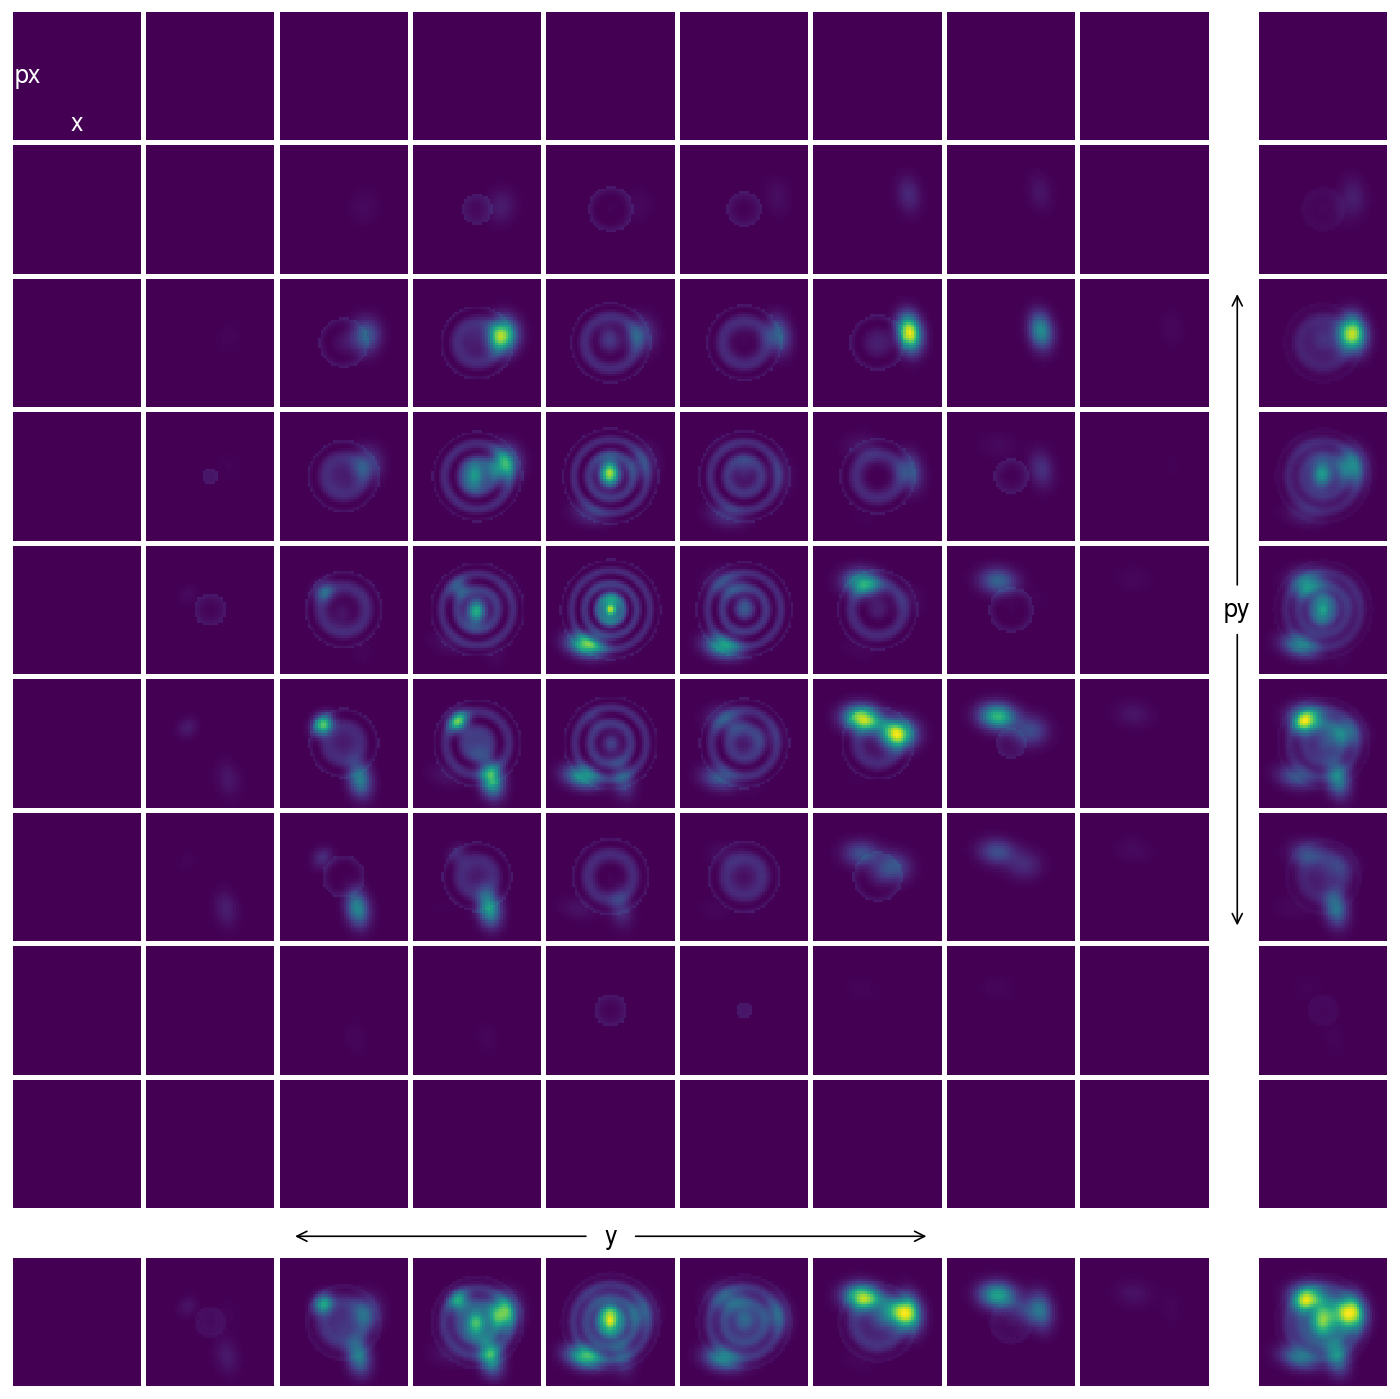

norm = log


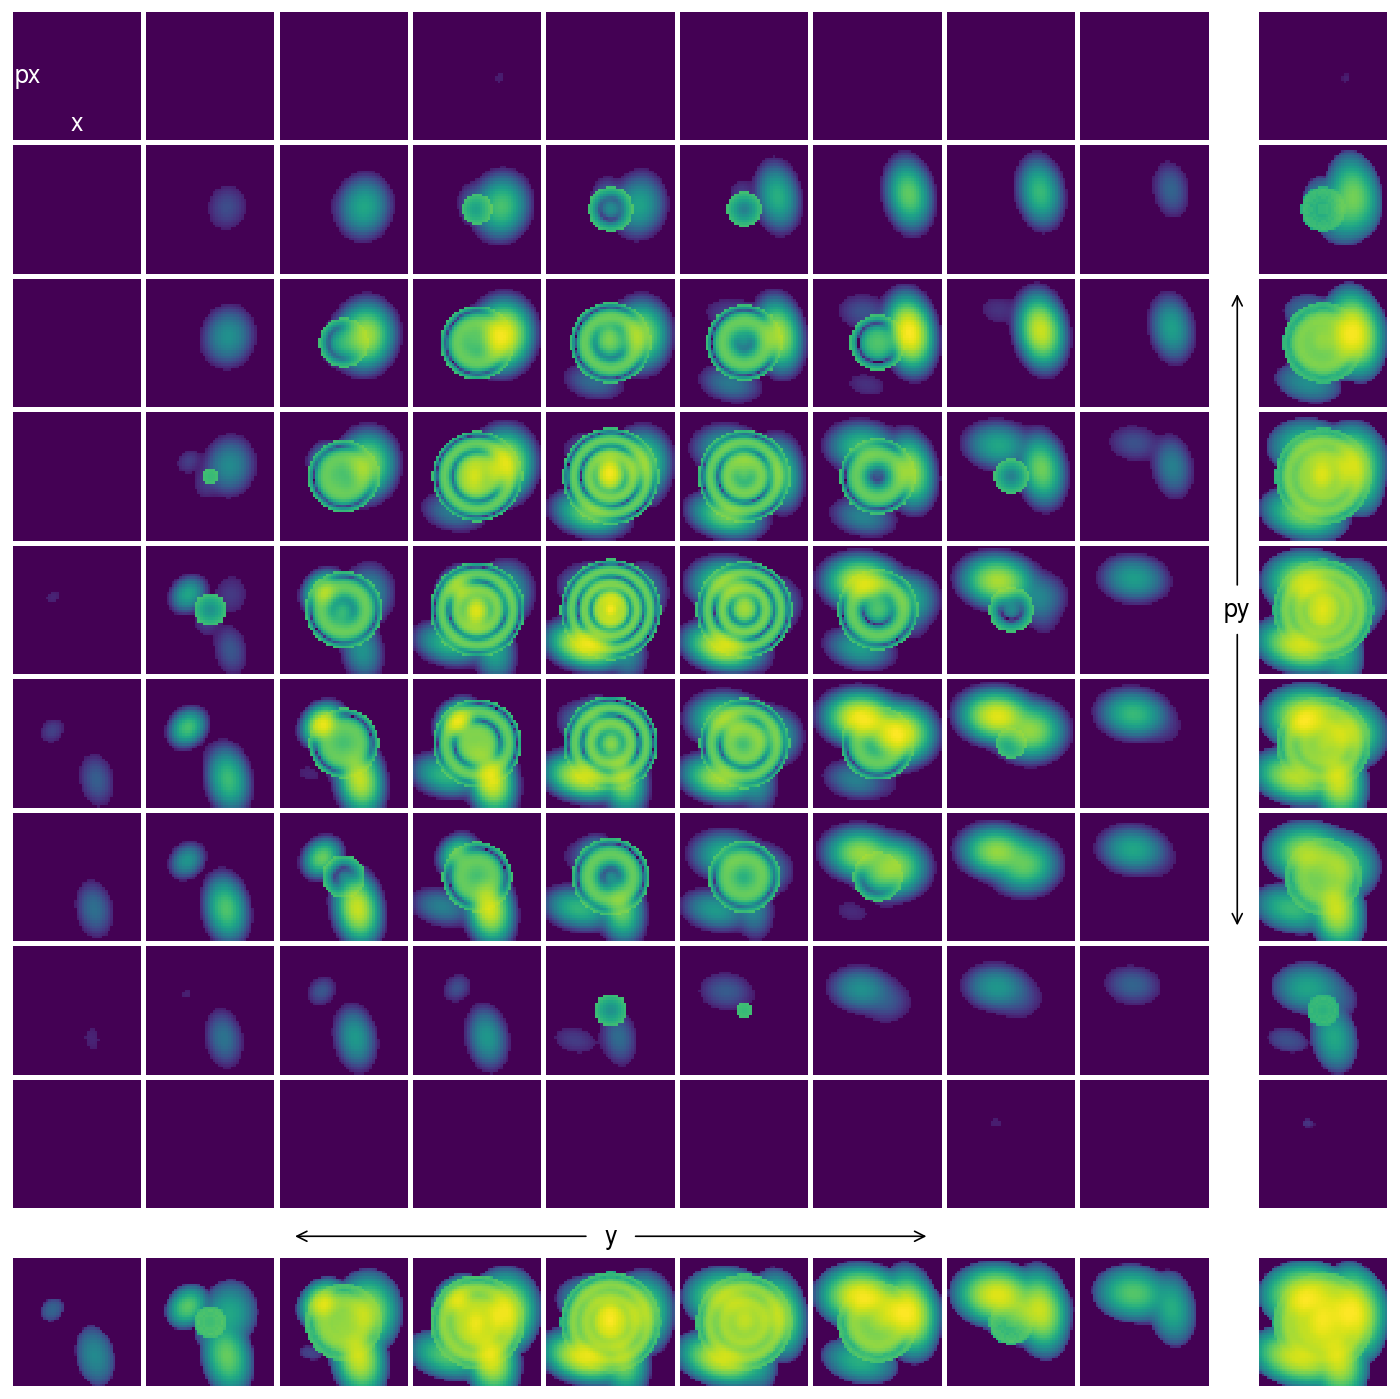

In [10]:
for norm in [None, "log"]:
    print("norm =", norm)
    
    grid = psv.SliceGrid(
        nrows=9,
        ncols=9,
        space=0.2,
        gap=2.0,
        marginals=True,
        annotate=True,
        annotate_kws_view=dict(color="white"),
        annotate_kws_slice=dict(color="black"),
        xspineloc="neither",
        yspineloc="neither",
        figwidth=7.0,
    )
    grid.plot_hist(
        hist.project(axis=(0, 1, 2, 3)),
        labels=dims,
        axis_view=(0, 1),
        axis_slice=(2, 3),
        vmax=1.0,  # shared cmap
        norm=norm,
        offset=1.0,  # offset to deal with zeros for log cmap
        debug=False,
    )
    plt.show()

(Can also call `psv.hist.def plot_slice_matrix(hist: Histogram, grid_kws: dict = None, **kws)`.)

### 1D projection with interactive slicing

In [11]:
psv.hist.plot_interactive_slice_1d(
    hist,
    dims=dims,
    slice_type="range",  # {"int", "range"}
    fig_kws=dict(ylabel="Density"),
    kind="step",
    fill=True,
)

interactive(children=(Dropdown(description='dim', options=('x', 'px', 'y', 'py'), value='x'), Checkbox(value=F…

### 2D projection with interactive slicing

In [12]:
psv.hist.plot_interactive_slice_2d(
    hist,
    slice_type="range",  # {"int", "range"}
    profiles_checkbox=True,
    kind="pcolor",
    cmap="viridis",
)

interactive(children=(Checkbox(value=False, description='profiles'), Checkbox(value=False, description='log'),…

### Contour slices

Here, we observe the 1D projection of the distribution within an ($N - 1$)-dimensional contour slice in the other dimensions. See https://arxiv.org/abs/2301.04178.

In [13]:
@interact(
    dim=widgets.Dropdown(options=dims, value=dims[0]),
    levels=widgets.FloatRangeSlider(
        description="(N-1) thresh",
        min=0.0,
        max=1.0,
        value=(0.0, 1.0),
        step=0.001,
        continuous_update=True,
    ),
)
def update(dim: int, levels: float):
    lmin, lmax = levels
    axis = dims.index(dim)

    hist_proj = ps.hist.project_contour_slice_1d(hist, axis=axis, lmin=lmin, lmax=lmax)
    hist_proj.normalize()

    fig, ax = plt.subplots(figsize=(4, 1.5))
    psv.hist.plot_1d(
        hist_proj,
        ax=ax,
        fill=True,
        color="black",
        lw=2.0,
    )
    ax.format(xlabel=dims[axis], ylabel="density")
    plt.show()

interactive(children=(Dropdown(description='dim', options=('x', 'px', 'y', 'py'), value='x'), FloatRangeSlider…

We can do the same thing with a 2D projection of the distribution within an ($N - 2$)-dimensional contour slice in the other dimensions.

In [14]:
@interact(
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    levels=widgets.FloatRangeSlider(
        description="(d-2) thresh",
        min=0.0,
        max=1.0,
        value=(0.0, 1.0),
        step=0.001,
        readback_format=".3f",
    ),
    log=False,
)
def update(dim1: int, dim2: int, levels: float, log: bool, **plot_kws):
    if dim1 == dim2:
        return
        
    axis = (dims.index(dim1), dims.index(dim2))
    lmin, lmax = levels
    
    hist_proj = ps.hist.project_contour_slice_2d(hist, axis=axis, lmin=lmin, lmax=lmax)

    plot_kws["norm"] = "log" if log else None
    plot_kws.setdefault("process_kws", dict(thresh=0.001, thresh_type="frac"))
    plot_kws.setdefault("colorbar", True)
    plot_kws.setdefault("profx", True)
    plot_kws.setdefault("profy", True)
    plot_kws.setdefault("offset", 1.0 if log else None)

    fig, ax = plt.subplots()
    ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    psv.plot_hist(hist_proj, ax=ax, **plot_kws)
    ax.format(xlim=sorted(ax.get_xlim()))
    plt.show()

interactive(children=(Dropdown(description='dim1', options=('x', 'px', 'y', 'py'), value='x'), Dropdown(descri…